### **Introduction**

Churn is a phenomenon that occurs when customers abandon a product by not making repeat purchases or repeat transactions for various reasons. Churn analysis is conducted to determine the risk of churn within a business process. This is done to avoid negative impacts on future business processes.

### **Import Library**

This stage is carried out to import several libraries required for data analysis and modeling

In [1]:
import tarfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

### **Data Understanding**

Some steps that will be carried out at this stage are taking the required dataset, looking at the number of data and columns, looking at the data type, detecting missing values, detecting duplicate data and determining the target variable.

1. Load Data

In [2]:
#Tar file extraction
with tarfile.open("3_test_data.tar", "r") as tar:
    tar.extractall("data")

In [3]:
os.listdir("data")

['test_data']

In [4]:
os.listdir("data/test_data")

['.part-00000-2622ca7b-bce3-4876-abb9-e10cadfcb7d6-c000.snappy.parquet.crc',
 '.part-00001-2622ca7b-bce3-4876-abb9-e10cadfcb7d6-c000.snappy.parquet.crc',
 '.part-00002-2622ca7b-bce3-4876-abb9-e10cadfcb7d6-c000.snappy.parquet.crc',
 '.part-00003-2622ca7b-bce3-4876-abb9-e10cadfcb7d6-c000.snappy.parquet.crc',
 '.part-00004-2622ca7b-bce3-4876-abb9-e10cadfcb7d6-c000.snappy.parquet.crc',
 '.part-00005-2622ca7b-bce3-4876-abb9-e10cadfcb7d6-c000.snappy.parquet.crc',
 '.part-00006-2622ca7b-bce3-4876-abb9-e10cadfcb7d6-c000.snappy.parquet.crc',
 '.part-00007-2622ca7b-bce3-4876-abb9-e10cadfcb7d6-c000.snappy.parquet.crc',
 '._SUCCESS.crc',
 'part-00000-2622ca7b-bce3-4876-abb9-e10cadfcb7d6-c000.snappy.parquet',
 'part-00001-2622ca7b-bce3-4876-abb9-e10cadfcb7d6-c000.snappy.parquet',
 'part-00002-2622ca7b-bce3-4876-abb9-e10cadfcb7d6-c000.snappy.parquet',
 'part-00003-2622ca7b-bce3-4876-abb9-e10cadfcb7d6-c000.snappy.parquet',
 'part-00004-2622ca7b-bce3-4876-abb9-e10cadfcb7d6-c000.snappy.parquet',
 'part

In [5]:
df = pd.read_parquet("data/test_data")

In [6]:
df.head()

,customer_id,trx_code,trx_date,amount
0,f1ff13d88f07f14a51dca8d35d6e6cddee07ffd2d3e225...,O,20230227,2000.0
1,f1ff13d88f07f14a51dca8d35d6e6cddee07ffd2d3e225...,O,20230227,7000.0
2,9da9198fb750e34a70f93cdb8e61833d6322289f126fd0...,O,20230227,7000.0
3,125f02a6b1220cb06010fb109f20b3dcbeda598b20898c...,O,20230227,7000.0
4,80b3fcc3421833c86af77814dd964349d555043586cbc5...,O,20230227,8500.0


The data set contains transaction data consisting of customer_id, trx_code, trx_date, and transaction amount. The following is an explanation of the columns:

| Columns Name | Explanation |
|:--------|:--------|
|  customer_id   |  customer identity   |
|  trx_code   |  transaction code   |
|  trx_date   |  transaction date   |
|  amount     |  transaction amount |

2. Looking at The Number of Data and Columns

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4861047 entries, 0 to 4861046
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  object 
 1   trx_code     object 
 2   trx_date     object 
 3   amount       float64
dtypes: float64(1), object(3)
memory usage: 148.3+ MB


In [8]:
df.shape

(4861047, 4)

In [9]:
df.columns

Index(['customer_id', 'trx_code', 'trx_date', 'amount'], dtype='object')

In [10]:
#Check for missing values
df.isnull().sum().sort_values(ascending=False)

customer_id    0
trx_code       0
trx_date       0
amount         0
dtype: int64

In [11]:
#Check for duplicate data
df.duplicated().sum()

1057023

In the df data, 1057023 data duplications were found. This data duplication is suspected to be transaction data and not purely duplicate data.

3. Determining The Target Variable

In [12]:
#Change mismatched data types
df['trx_date'] = pd.to_datetime(df['trx_date'])

In [13]:
#Search the customer's last trasnsaction
customer_df = (
    df.groupby('customer_id').agg(
        last_trx_date =('trx_date', 'max'),
        n_trx_code = ('trx_code', 'nunique'),
        frequency =('trx_code', 'count'),
        monetary =('amount', 'sum')
    ).reset_index()
)
reference_date = df['trx_date'].max()

#Calculate recency
customer_df['recency_days'] =(reference_date - customer_df['last_trx_date']).dt.days

In [14]:
#Search threshold to get churn
customer_df['recency_days'].describe()

count    119174.000000
mean         12.081326
std          16.588968
min           0.000000
25%           1.000000
50%           4.000000
75%          18.000000
max          89.000000
Name: recency_days, dtype: float64

In [15]:
#Create a churn target
customer_df['churn'] = (customer_df['recency_days'] > 30).astype(int)

In [16]:
customer_df.head()

,customer_id,last_trx_date,n_trx_code,frequency,monetary,recency_days,churn
0,0001a21cfd59d4b0f600dc9a4285f3526f09d9a4c6f760...,2023-03-31,2,29,16664012.0,0,0
1,000278232d3e0100eccab5448d4ecc0a7603cc928d8960...,2023-03-31,3,87,39799174.0,0,0
2,0002bffa6cae89a007e1ed1a84b73cc9a0d34efcb1c856...,2023-03-31,2,21,17171042.0,0,0
3,00037010e7029fe1c144acade150d21c9be37fc551dd75...,2023-03-31,3,33,373360638.0,0,0
4,00040d980e62a4c181d6c0f2a751f90b50fe2300ea03ce...,2023-03-29,2,18,76711481.0,2,0


The steps in finding the target variable are to form a new data frame called customer_df which is taken from df so that it becomes:

|  Columns Name  |   Explanation    |
| :--------------| :--------------- |
| customer_id    | customer identity|
| last_trx_code  | last transaction date, taken from trx_code |
| n_trx_code     | a collection of transaction codes per customer, taken from trx_code.nunique() |
| frequency      | Number of transaction codes per customer |
| monetary       | Total transactions made by customers |
| recency_days   | The difference in transaction days made by customers based on today's date and the last transaction date |

Customers are detected as churned if they do not make a transaction for more than 30 days, because the highest recency_days value occurs for 89 days.

### **Data Cleaning & Preparation**

In [17]:
#Checked duplicate data in customer_df
customer_df.duplicated().sum()

0

In [18]:
#Checked whether duplicate data in df needs to be deleted or not
df.groupby(['customer_id', 'trx_code', 'trx_date']).amount.value_counts()

customer_id                                                       trx_code  trx_date    amount  
0001a21cfd59d4b0f600dc9a4285f3526f09d9a4c6f760dde22cb3bd1b9e7ae2  O         2023-01-02  7500.0      2
                                                                            2023-01-16  630584.0    1
                                                                            2023-01-30  4553.0      1
                                                                                        22766.0     1
                                                                            2023-02-02  7500.0      2
                                                                                                   ..
ffff94e64a0acfa2b984c2f1b0f600ae46833abab6ea8089d6a89b1c63831517  O         2023-01-01  31.0        1
                                                                            2023-02-01  31.0        1
                                                                            2023-03-01 

Duplication in df is proven to be transaction data so it cannot be made into pure duplication and is deleted.

In [19]:
#Checked missing value in customer df
customer_df.isnull().sum()

customer_id      0
last_trx_date    0
n_trx_code       0
frequency        0
monetary         0
recency_days     0
churn            0
dtype: int64

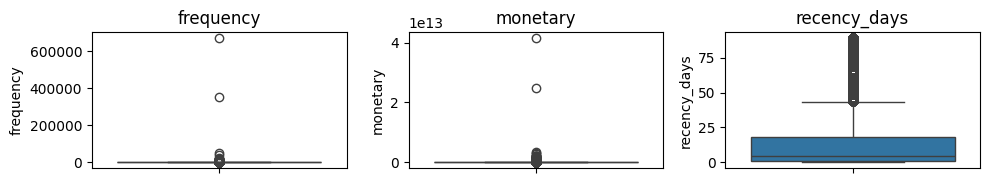

In [20]:
#Checked outlier in customer_df
num_feat = ['frequency', 'monetary', 'recency_days']
plt.figure(figsize=(10, 5))
for i, col in enumerate(num_feat):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=customer_df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

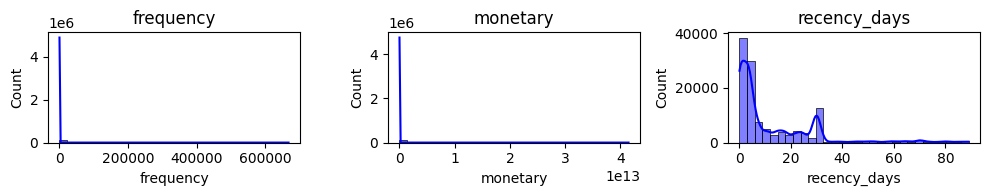

In [21]:
num_feat = ['frequency', 'monetary', 'recency_days']
plt.figure(figsize=(10, 5))
for i, col in enumerate(num_feat,1):
    plt.subplot(3, 3, i)
    sns.histplot(customer_df[col], bins=30, kde=True, color='blue')
    plt.title(col)
plt.tight_layout()
plt.show()

The outlier detection step revealed the following:  
In Frequency, the following occurred:
  - The distribution is highly skewed to the right (right-skewed).
  - The majority of customers have very low frequencies.
  - There are a few customers with very high frequencies (outliers).
    
Most customers rarely make transactions, while only a few are very active (heavy users/loyal).  

In Monetary, the following occurred:  
- Much more extreme skewing to the right than in Frequency.
- The majority of customers make small transactions.
- There are outliers with very large spending values ​​(even up to 1e13 → indicating highly abnormal data).
  
Most customers are low-value, a few customers contribute very large revenue (the 80/20 Pareto principle), and Monetary is not normally distributed.  

In Recency_days, the following occurred:  
- Many customers have low recency (0–10 days).
- There is a long tail of up to ~90 days.
- Still skewed, but more reasonable than in Frequency & Monetary.

Many customers are still active, there are groups of customers who have not made transactions for a long time → churn candidates

In [22]:
#Steps to overcome outliers
#1. Perform log transform on frequency and monetary
customer_df['frequency_log'] = np.log1p(customer_df['frequency'])
customer_df['monetary_log'] = np.log1p(customer_df['monetary'])

In [23]:
#2. Scaling use Robustscaler on frequency, monetary and recency_days
scaler = RobustScaler()
customer_df[['frequency_log', 'monetary_log']] =scaler.fit_transform(
    customer_df[['frequency_log', 'monetary_log']]
)

customer_df[['recency_days_scale']] = scaler.fit_transform(customer_df[['recency_days']])

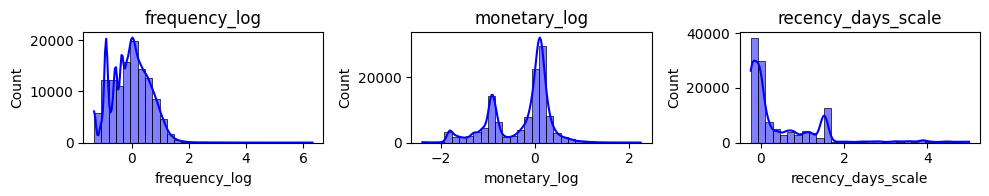

In [24]:
num_feat = ['frequency_log', 'monetary_log', 'recency_days_scale']
plt.figure(figsize=(10, 5))
for i, col in enumerate(num_feat,1):
    plt.subplot(3, 3, i)
    sns.histplot(customer_df[col], bins=30, kde=True, color='blue')
    plt.title(col)
plt.tight_layout()
plt.show()

After handling outliers, the graph looks better than before.

### **Exploratory Data Analysis**

In [25]:
df['trx_code'].value_counts()

trx_code
O    2335562
T    1943085
B     565049
F      17351
Name: count, dtype: int64

In [26]:
df.groupby('customer_id')['trx_code'].nunique()

customer_id
0001a21cfd59d4b0f600dc9a4285f3526f09d9a4c6f760dde22cb3bd1b9e7ae2    2
000278232d3e0100eccab5448d4ecc0a7603cc928d896076d596290263dcd833    3
0002bffa6cae89a007e1ed1a84b73cc9a0d34efcb1c8564cd7117158c9f71baf    2
00037010e7029fe1c144acade150d21c9be37fc551dd7501137da85eed9c64c7    3
00040d980e62a4c181d6c0f2a751f90b50fe2300ea03ce4763391df734175fd5    2
                                                                   ..
fffc8387bc30d2f0ad0e022af05f200af727bc34fe5448ef3e8336b0e0c8bb50    3
fffd42a0842f72b1e63e2de5f64d9e14c3140d25ea43c1541084649069e74d74    2
fffdbb8b6346731047cec8d74631f533be62993418d28fd1dae8c2e49d6f3afc    4
ffff77cdbb7ecce237eaac5492b95d77f9d0c2b545174dd81e524a36e96ede02    2
ffff94e64a0acfa2b984c2f1b0f600ae46833abab6ea8089d6a89b1c63831517    2
Name: trx_code, Length: 119174, dtype: int64

In [27]:
#Overview target
customer_df['churn'].value_counts(normalize=True)

churn
0    0.936303
1    0.063697
Name: proportion, dtype: float64

In [28]:
customer_df['churn'].value_counts()

churn
0    111583
1      7591
Name: count, dtype: int64

In [29]:
customer_df.describe()

,last_trx_date,n_trx_code,frequency,monetary,recency_days,churn,frequency_log,monetary_log,recency_days_scale
count,119174,119174.000000,119174.000000,1.191740e+05,119174.000000,119174.000000,119174.000000,1.191740e+05,119174.000000
mean,2023-03-18 22:02:53.393525504,2.103596,40.789493,1.305173e+09,12.081326,0.063697,-0.025276,-2.880320e-01,0.475372
min,2023-01-01 00:00:00,1.000000,1.000000,1.000000e+00,0.000000,0.000000,-1.319648,-2.388092e+00,-0.235294
25%,2023-03-13 00:00:00,1.000000,6.000000,4.900000e+04,1.000000,0.000000,-0.567242,-8.596715e-01,-0.176471
50%,2023-03-27 00:00:00,2.000000,17.000000,1.441882e+07,4.000000,0.000000,0.000000,-2.686422e-16,0.000000
75%,2023-03-30 00:00:00,3.000000,36.000000,3.646802e+07,18.000000,0.000000,0.432758,1.403285e-01,0.823529
max,2023-03-31 00:00:00,4.000000,668486.000000,4.147082e+13,89.000000,1.000000,6.319731,2.249120e+00,5.000000
std,NaN,0.894392,2196.436047,1.424671e+11,16.588968,0.244213,0.642574,6.284709e-01,0.975822


Information obtained from data exploration revealed that churn occurred and did not occur, with 111,583 customers not churning and 7,591 customers churning, or 93% non-churn and 6% churning. This means there is a data imbalance in the churn results. Even though the data that appears is imbalanced, sampling was not carried out to balance it because the minority class is at the point >5%.

### **Visualization**

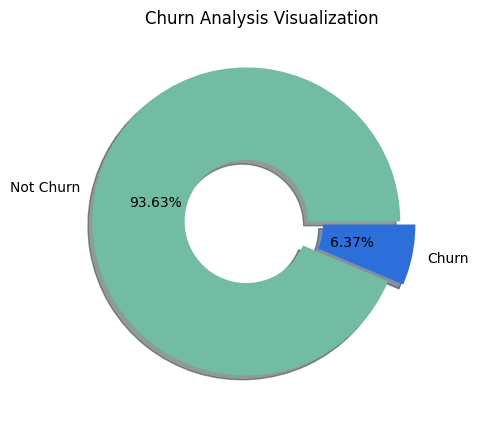

In [30]:
plt.figure(figsize=(10, 5))

colors = ["#73bca4", "#2c6fda"]

explode = (0.1, 0)

counts_cos = customer_df['churn'].value_counts()
labels = counts_cos.index.map({
    0: 'Not Churn',
    1: 'Churn',
})

plt.pie(
    x=customer_df['churn'].value_counts(),
    labels = labels,
    autopct ='%1.2f%%',
    colors = colors,
    explode = explode,
    shadow = True,
    wedgeprops ={'width' : 0.6}
)

plt.title("Churn Analysis Visualization")
plt.show()

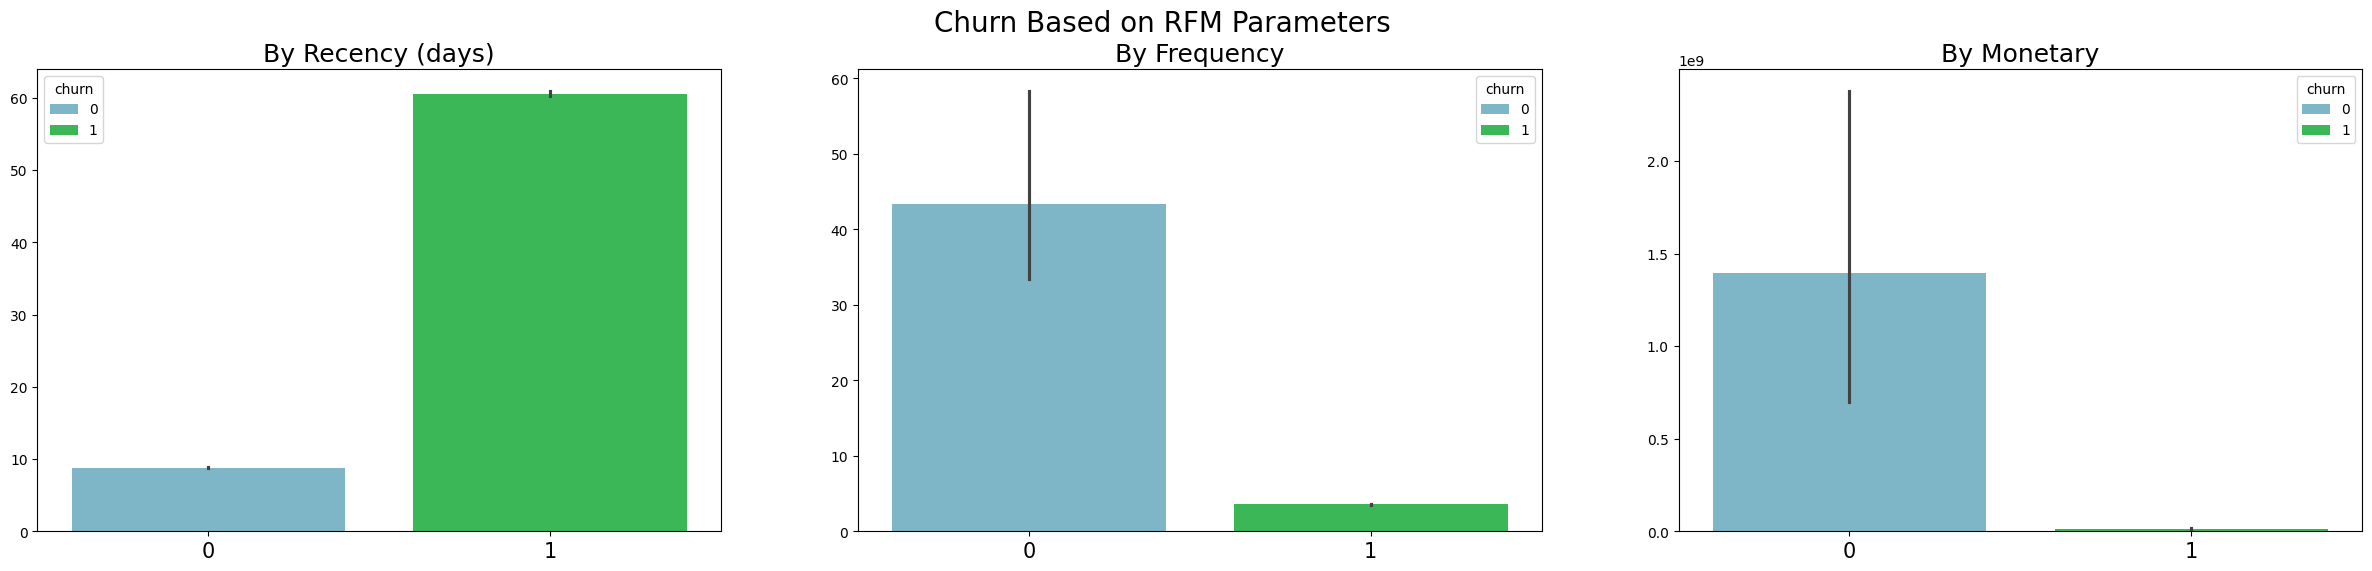

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,6))

colors = ["#72BCD4", "#27CB4D"]

sns.barplot(y="recency_days", x="churn", data=customer_df.sort_values(by="recency_days", ascending=True), hue="churn", palette=colors, ax=ax[0])
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].set_title("By Recency (days)", loc="center", fontsize=18)
ax[0].tick_params(axis='x', labelsize=15)

sns.barplot(y="frequency", x="churn", data=customer_df.sort_values(by="frequency", ascending=True), hue="churn", palette=colors, ax=ax[1])
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].set_title("By Frequency", loc="center", fontsize=18)
ax[1].tick_params(axis='x', labelsize=15)

sns.barplot(y="monetary", x="churn", data=customer_df.sort_values(by="monetary", ascending=True), hue="churn", palette=colors, ax=ax[2])
ax[2].set_ylabel(None)
ax[2].set_xlabel(None)
ax[2].set_title("By Monetary", loc="center", fontsize=18)
ax[2].tick_params(axis='x', labelsize=15)

plt.suptitle("Churn Based on RFM Parameters", fontsize=20)
plt.show()

In the recency_days graph, it was found that the tendency to churn is greater than not to churn. However, in frequency and monetary terms, the tendency not to churn is greater than to churn.

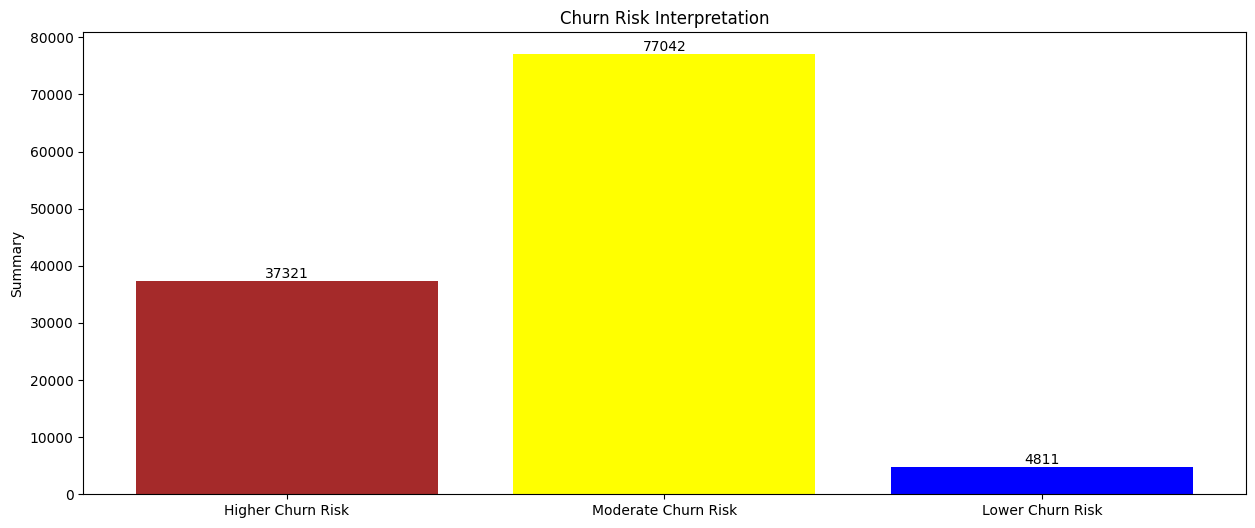

In [32]:
#Binning churn risk by n_trx_code
low =customer_df.n_trx_code[customer_df.n_trx_code == 1]
medium =customer_df.n_trx_code[(customer_df.n_trx_code >= 2) & (customer_df.n_trx_code <= 3)]
high =customer_df.n_trx_code[customer_df.n_trx_code >= 4]

#Menyusun data untuk plotting
x = ["Higher Churn Risk", "Moderate Churn Risk", "Lower Churn Risk"]
y = [len(low.values), len(medium.values), len(high.values)]

#Membuat bar chart untuk distribusi usia pelanggan
plt.figure(figsize=(15,6))
plt.bar(x, y, color=['brown', 'yellow', 'blue'])
plt.title("Churn Risk Interpretation")
plt.xlabel(None)
plt.ylabel("Summary")

#Menambah label jumlah pelanggan diatas setiap bar
for i in range(len(x)):
    plt.text(i, y[i], y[i], ha='center', va='bottom')

plt.show()

In [33]:
#Create categorical feature after binning
customer_df['churn_risk'] = customer_df['n_trx_code'].apply(lambda x:"Higher Churn Risk" if x == 1 else("Moderate Churn Risk" if x <= 3 else  "Lower Churn Risk"))

In [34]:
customer_df.head()

,customer_id,last_trx_date,n_trx_code,frequency,monetary,recency_days,churn,frequency_log,monetary_log,recency_days_scale,churn_risk
0,0001a21cfd59d4b0f600dc9a4285f3526f09d9a4c6f760...,2023-03-31,2,29,16664012.0,0,0,0.306801,0.021886,-0.235294,Moderate Churn Risk
1,000278232d3e0100eccab5448d4ecc0a7603cc928d8960...,2023-03-31,3,87,39799174.0,0,0,0.953128,0.153548,-0.235294,Moderate Churn Risk
2,0002bffa6cae89a007e1ed1a84b73cc9a0d34efcb1c856...,2023-03-31,2,21,17171042.0,0,0,0.120522,0.026419,-0.235294,Moderate Churn Risk
3,00037010e7029fe1c144acade150d21c9be37fc551dd75...,2023-03-31,3,33,373360638.0,0,0,0.381973,0.492111,-0.235294,Moderate Churn Risk
4,00040d980e62a4c181d6c0f2a751f90b50fe2300ea03ce...,2023-03-29,2,18,76711481.0,2,0,0.032473,0.252787,-0.117647,Moderate Churn Risk


In [35]:
customer_df['churn_risk'].value_counts()

churn_risk
Moderate Churn Risk    77042
Higher Churn Risk      37321
Lower Churn Risk        4811
Name: count, dtype: int64


Churn risk categories were grouped into three categories. The first category is Higher Churn Risk with a limit of n_trx_code = 1, the second category is Moderate Churn Risk with a limit of n_trx_code >= 2 and <= 3, and finally Lower Churn Risk with a limit of n_trx_code >= 4. The graph shows that the category of non-churn occurs mostly in the Moderate Churn Risk position with a total of 77,042 customers, which means that at some point it could change to a higher or lower churn risk.

In [36]:
#Encoding on churn_int after binning
or_enc = OrdinalEncoder(categories=[['Higher Churn Risk', 'Moderate Churn Risk', 'Lower Churn Risk']])
customer_df['churn_risk'] = or_enc.fit_transform(customer_df[['churn_risk']])
customer_df.head()

,customer_id,last_trx_date,n_trx_code,frequency,monetary,recency_days,churn,frequency_log,monetary_log,recency_days_scale,churn_risk
0,0001a21cfd59d4b0f600dc9a4285f3526f09d9a4c6f760...,2023-03-31,2,29,16664012.0,0,0,0.306801,0.021886,-0.235294,1.0
1,000278232d3e0100eccab5448d4ecc0a7603cc928d8960...,2023-03-31,3,87,39799174.0,0,0,0.953128,0.153548,-0.235294,1.0
2,0002bffa6cae89a007e1ed1a84b73cc9a0d34efcb1c856...,2023-03-31,2,21,17171042.0,0,0,0.120522,0.026419,-0.235294,1.0
3,00037010e7029fe1c144acade150d21c9be37fc551dd75...,2023-03-31,3,33,373360638.0,0,0,0.381973,0.492111,-0.235294,1.0
4,00040d980e62a4c181d6c0f2a751f90b50fe2300ea03ce...,2023-03-29,2,18,76711481.0,2,0,0.032473,0.252787,-0.117647,1.0


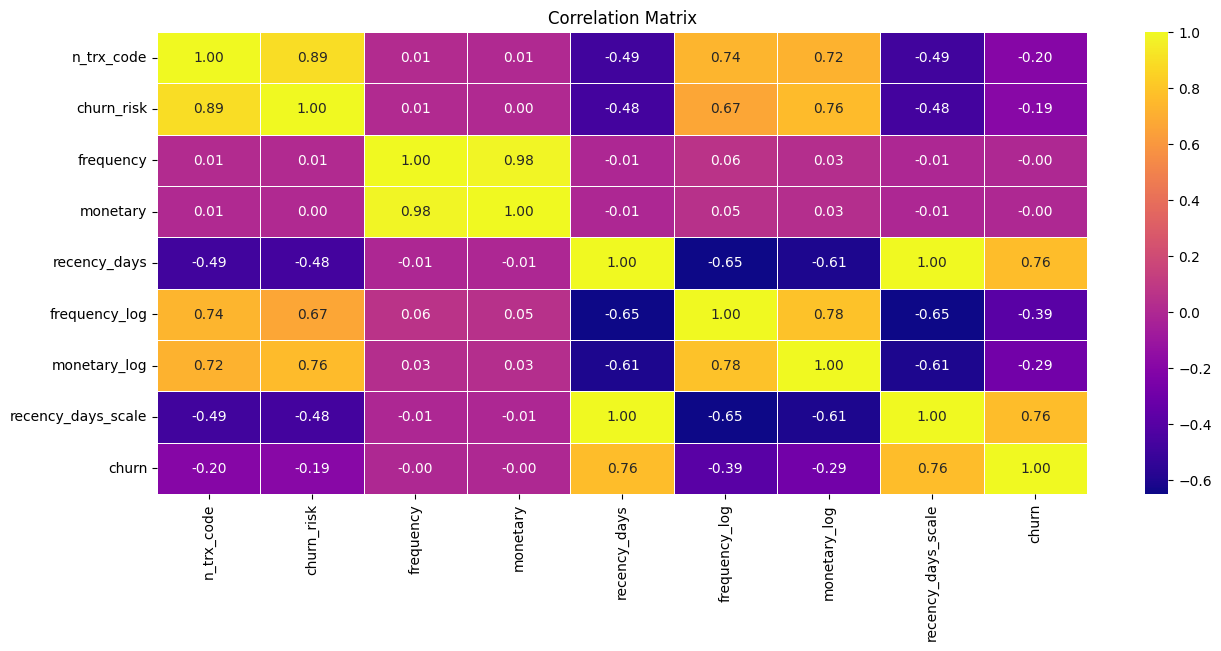

In [37]:
#Correlation matrix for numeric features
num_feat = ['n_trx_code','churn_risk', 'frequency', 'monetary', 'recency_days','frequency_log', 'monetary_log', 'recency_days_scale', 'churn']
plt.figure(figsize=(15,6))
corr_matrix = customer_df[num_feat].corr()
sns.heatmap(corr_matrix, annot=True, cmap='plasma', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

From the heatmap, it was found that the features that correlated more than 0.7 were n_trx_code with churn_risk 0.89, frequency_log 0.74 and monetary_log 0.72, churn_risk with monetary_log 0.76, frequency with monetary 0.98, recency_days with churn 0.76, frequency_log with monetary_log 0.78, recency_days_scale with churn 0.76 and recency_days 1, churn with recency_days 0.76. This shows that many features are interconnected and strengthen each other to produce targets according to the labels that have been obtained.

In [38]:
new_feat = customer_df[['n_trx_code','churn_risk', 'frequency_log', 'monetary_log', 'recency_days_scale', 'churn']]
new_df = pd.DataFrame(new_feat)

In [39]:
new_df.to_csv('new_feat.csv', index=False)

### **Modeling**

In [85]:
mod_df = pd.read_csv('new_feat.csv')
mod_df.head()

,n_trx_code,churn_risk,frequency_log,monetary_log,recency_days_scale,churn
0,2,1.0,0.306801,0.021886,-0.235294,0
1,3,1.0,0.953128,0.153548,-0.235294,0
2,2,1.0,0.120522,0.026419,-0.235294,0
3,3,1.0,0.381973,0.492111,-0.235294,0
4,2,1.0,0.032473,0.252787,-0.117647,0


In [86]:
#Data Splitting
X = mod_df.drop(columns=['churn'])
y = mod_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training set shape: X_train=(95339, 5), y_train=(95339,)
Test set shape: X_test=(23835, 5), y_test=(23835,)


In [87]:
#Build a classification model
logreg =LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
logreg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [90]:
#Class prediction (default threshold 0.5)
y_pred = logreg.predict(X_test)

#Probability prediction (for AUC)
y_proba = logreg.predict_proba(X_test)[:,1]

In [93]:
#Model Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

print("ROC-AUC :", roc_auc_score(y_test, y_proba))
print("PR-AUC :", average_precision_score(y_test, y_proba))

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22300
           1       0.98      1.00      0.99      1535

    accuracy                           1.00     23835
   macro avg       0.99      1.00      0.99     23835
weighted avg       1.00      1.00      1.00     23835

Confusion Matrix:

[[22271    29]
 [    3  1532]]
ROC-AUC : 0.9999834358247761
PR-AUC : 0.9997646085723115


In [94]:
#see the churn opportunity through the coefficient
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': logreg.coef_[0]
}).sort_values(by='coefficient', ascending=False)
coef_df

,feature,coefficient
4,recency_days_scale,36.589017
3,monetary_log,2.013165
0,n_trx_code,1.092655
1,churn_risk,-0.022864
2,frequency_log,-3.034866


### **Questions**

Q : Why do we need to perform churn analysis?  
A : Churn analysis is conducted to evaluate customers who stop subscribing to a product or transaction. Through churn analysis, we can identify the causes. After identifying churn occurrences in a business process, business owners are expected to anticipate and prevent further churn.  

Q : How can we identify customers who are likely to churn?  
A : From the RFM visualization, it can be seen that customers who are potentially at risk of churning are those whose recency_days exceed the specified time limit (in this case, >30 days). This should be analyzed to find ways to prevent customers from having a large recency_days, so they don't have the potential to churn. A possible solution is to offer promotions at certain times specifically for customers when the time limit is detected to prevent churn. However, this should also be accompanied by a better customer transaction frequency and a higher customer monetary value to ensure a more complete indication of no churn. This is because transaction frequency and monetary value contribute to a no-churn condition. This can be seen from the RFM graph, which shows that frequency and monetary values ​​have more non-churn customers than churned customers.

Q :  What metrics can be used?  
A : The metrics used include:
- Classification Report with a 100% non-churn (0) prediction result in terms of precision, recall, and F1-score. While the churn (1) prediction result varied, with a precision of 98%, a recall of 100%, and an F1-score of 99%. Both classes experienced imbalanced data, with 22,300 non-churn support and 1,535 churn support.
In this classification report, accuracy is 100%, but caution is needed in case of data leakage. Macro Avg displays an F1 result of 0.99, indicating the model is fair to the minority class. Weighted Avg displays 100% results for all metrics, with class 0 dominant and performing perfectly.
- Confusion Matrix
  | Class | Negative  |  Positive  |
  | :-----: | :------:  | :--------: |
  |  0    |  22,271 (TN)| 29 (FP) |
  |  1    | 3 (FN)  | 1532 (TP)|

  From the table, it can be seen that only data in class 1 was predicted incorrectly (FN), and there were 29 class 0 data that were predicted to churn when they did not, but were still acceptable. However, there are things that need to be anticipated if FP occurs which indicates the wrong targeting of customers who are actually loyal, this results in unnecessary promotional costs, and also business actors must be aware of FN which causes business actors to not be aware of customers who leave.
- ROC-AUC 0.9998 shows the model's near-perfect ability to distinguish between classes 0 and 1.
- PR-AUC 0.99976 is important for imbalanced data, with precision and recall remaining high, the model is very reliable for detecting minority classes.

Q : How does your analysis support the importance of performing churn analysis?  
A : Churn analysis provides an overview containing information on the triggering factors for churn, the magnitude of the risk of churn, and the amount of churn that has already occurred. Churn analysis provides a warning so that businesses can strive to prevent customer churn. This is also accompanied by actions supported by improvements in service and innovation in the products produced, in the hope that customers feel helped and really need the products produced.

### **Recommendation**


Based on the coefficients generated by the model, three features were identified as potentially increasing churn and should be monitored closely. The recency_days_scale feature (the scaled recency_days feature) was the largest predictor of churn, with a coefficient of 36.59, followed by monetary_log (the log-transformed and scaled monetary feature) with a coefficient of 2.01, and n_trx_code with a coefficient of 1.09. This indicates:  
- The greater a customer's recency_days, the greater the risk of churn, making recency_days the largest predictor of churn risk. Businesses are expected to encourage customers to continue making transactions by offering ongoing promotions to create a sense of value for them.
- Similarly, with monetary_log, if a large number of transactions are made, this will cause customers to reduce their transaction frequency. This is inversely proportional to the RFM graph. Therefore, businesses can anticipate customers making large transactions at once by advertising products with small but beneficial transactions so that customers will make transactions frequently.
- The chance of n_trx_code causing churn is small, but it still needs to be monitored because if customers no longer make transactions, n_trx_code will automatically affect recency_days and this will trigger churn. A recommendation is to provide customers with ongoing promotions with various types of transactions at different times to generate a large number of n_trx_codes and minimize recency_days.

However, there's good news: the frequency coefficient shows a result of (-3.03), indicating that the chance of churn will decrease (negative) if transaction frequency can be increased. Likewise, the churn_risk coefficient is (-0.02). If business owners can reduce (negative) the risk of churn, the potential for churn will be reduced.

### **Conclusion**

In conclusion, the developed churn model performs well in identifying at-risk customers, particularly those with adequate recall. The interpretation reveals that the primary factors that increase churn are recency_days (the time since the last transaction), followed by monetary (transaction value), and n_trx_code (the number of transaction types). In other words, the longer a customer has not transacted, the lower the transaction value, and the fewer service variations they use, the higher the risk of customer churn.  

Going forward, the focus of retention strategies should be directed at moderate-risk customers, through a transaction reactivation approach, tailored service offerings, and more personalized engagement programs.